### Optimization for Machine Learning - Stochastic gradient methods

### Paris Dauphine University - PSL Research University

# IASD Project #5 : Stochastic BFGS methods 

January 19, 2024

Student: MERIGOT Jules

# Introduction

In [2]:
import numpy as np
import sklearn
from sklearn.datasets import load_svmlight_file
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

import numpy as np
from numpy.random import multivariate_normal, randn

from scipy.linalg import toeplitz
from scipy.linalg import svdvals
from scipy.linalg import norm
from scipy.optimize import check_grad
from scipy.optimize import fmin_l_bfgs_b

## Question 1

Let's select a training dataset for binary classification of the form $\{(a_i, y_i)\}_{i=1}^n$ with $a_i \in \mathbb{R}^d$ and $y_i \in (0,1)$. In order to load the dataset in Python, we'll use the routine `sklearn.datasets.load_svmlight_file` from the sickit-learn library.

Data can be found here: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a

In [4]:
# Loading the data

#A, y = load_svmlight_file("C:/Users/jules/OneDrive/Desktop/Opti_Project/mushrooms.txt")
A, y = load_svmlight_file("C:/Users/jules/OneDrive/Desktop/Opti_Project/a7a.txt")
print(A.shape)

(16100, 122)


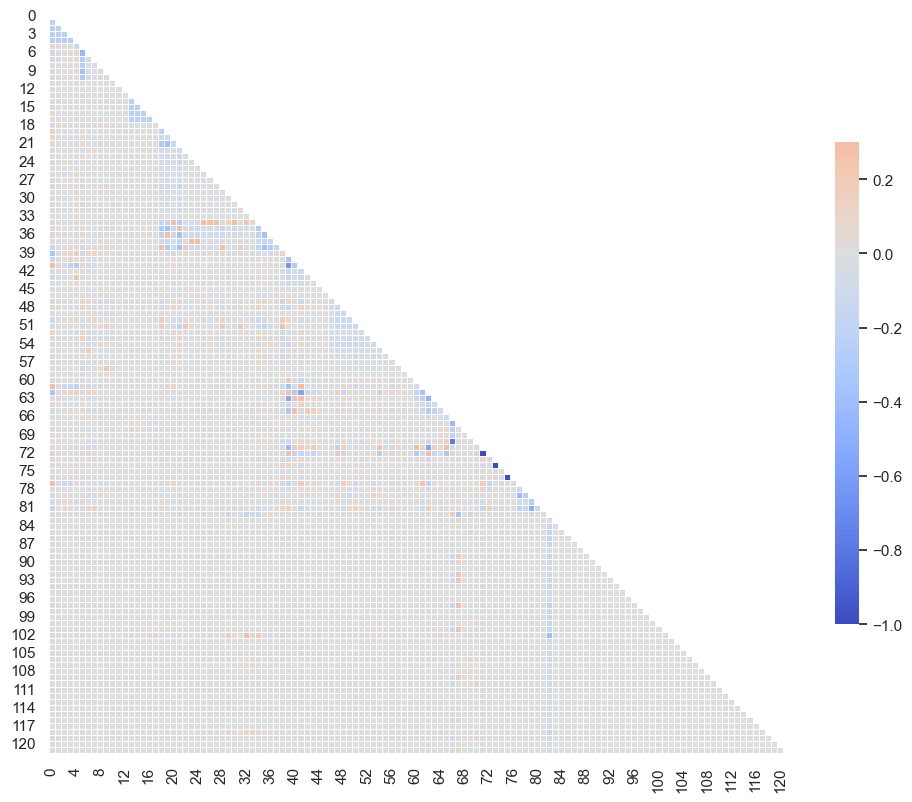

In [5]:
# Correlation Matrix heatmap

A_dense = A.toarray()
correlation_matrix = np.corrcoef(A_dense, rowvar=False)

sns.set(style="white")

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False, fmt=".2f")
plt.tight_layout()
plt.show()

## Question 2

In [6]:
# Create the Binary Classification object class

class BinClass(object):
    def __init__(self, A, y):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        
    def lipgrad(self):
        # compute the square of each element in the matrix, summing over the rows, and then taking the max
        L = np.max(np.sum(self.A.multiply(self.A), axis=1))
        return L
    
    def fun(self, x):
        Ax = self.A.dot(x)
        f = (self.y - 1/(1+np.exp(-Ax))) ** 2
        return np.mean(f)
    
    def f_i(self, i, x):
        Axi = self.A[i].dot(x)
        f_i = (self.y[i] - 1/(1+np.exp(-Axi))) ** 2
        return f_i
    
    def grad(self, x):
        Aix = self.A.dot(x)
        exp_Aix = np.exp(Aix)
        num = 2 * exp_Aix * (exp_Aix * (self.y - 1) + self.y)
        denom = (1 + exp_Aix) ** 3
        grad = -(num / denom) * self.A
        return grad / self.n

    def grad_i(self, i, x):
        Aix = self.A[i].dot(x).astype(float)
        exp_Aix = np.exp(Aix)
        num = 2 * exp_Aix * (exp_Aix * (self.y[i] - 1) + self.y[i])
        denom = (1 + exp_Aix) ** 3
        grad = -(num / denom) * self.A[i]
        return grad

In [7]:
# Generate the problem instance

#binclass_a9a = BinClass(X, y_subset)
ylog = np.sign(y)
n, d = A.shape
lbda = 1. / n ** (0.5)
#binclass_a9a = BinClass(A, ylog, lbda)

binclass_a9a = BinClass(A, ylog)

In [9]:
# Check correctness of the gradient functions compared to a finite-difference estimate
# Note: this is a check of the implementation of the gradient and the function value. If correct, the 
# output value, which represents the difference between a gradient and its estimation from function values, 
# should be of order 1e-06 at most.

np.random.seed(1)

n, d = A.shape
print(A.shape)

print(check_grad(binclass_a9a.fun, binclass_a9a.grad, np.random.randn(d)))

grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    grad_error.append((binclass_a9a.f_i( ind[0], w+eps*vec) - binclass_a9a.f_i( ind[0], w))/eps - np.dot(binclass_a9a.grad_i(ind[0],w),vec)) 
print(np.mean(grad_error))

(16100, 122)
1.0187024514948115e-07
3.4064537050720435e-09


In [10]:
# Use L-BFGS-B to determine a solution for both problems

x_init = np.zeros(d)

# Compute the optimal solution for logistic regression
x_min, f_min, _ = fmin_l_bfgs_b(binclass_a9a.fun, x_init, binclass_a9a.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min)
print(norm(binclass_a9a.grad(x_min)))

0.9414365630729674
8.067317722119264e-10


In [12]:
# Stochastic gradient implementation
def stoch_grad(x0, problem, xtarget, stepchoice=0, step0=1, n_iter=1000, nb=1, with_replace=False, verbose=True): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                t>0: Step size decreasing in 1/(k+1)**t
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            x_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj)
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=",nb,"/",n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n, nb, replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            x[:] = x - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 

        obj = problem.fun(x)
        nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)

In [136]:
# Compare implementations of gradient descent/stochastic gradient
# Pay attention to the budget allocated to each solver (the cost of one iteration of gradient descent vs 
# the cost of 1 iteration of stochastic gradient are different)

nb_epochs = 60
n = binclass_a9a.n
nbset = 1
x0 = np.zeros(d)

# Run a - Gradient descent with constant stepsize
x_a, obj_a, nits_a = stoch_grad(x0, binclass_a9a, x_min, stepchoice=0, step0=1, n_iter=nb_epochs, nb=n)

# Run b - Stochastic gradient with constant stepsize
# The version below may diverge, in which case the bound on norm(w) in the code will be triggered
x_b, obj_b, nits_b = stoch_grad(x0, binclass_a9a, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs*n/nbset), nb=1)

Stochastic Gradient, batch size= 16100 / 16100
  iter   |   fval   |  normit 
       0 | 1.76e+00 | 2.10e+02
       1 | 1.65e+00 | 2.10e+02
       2 | 1.55e+00 | 2.10e+02
       3 | 1.47e+00 | 2.10e+02
       4 | 1.41e+00 | 2.10e+02
       5 | 1.36e+00 | 2.10e+02
       6 | 1.31e+00 | 2.10e+02
       7 | 1.28e+00 | 2.10e+02
       8 | 1.25e+00 | 2.10e+02
       9 | 1.23e+00 | 2.10e+02
      10 | 1.21e+00 | 2.10e+02
      11 | 1.19e+00 | 2.10e+02
      12 | 1.18e+00 | 2.10e+02
      13 | 1.16e+00 | 2.10e+02
      14 | 1.15e+00 | 2.10e+02
      15 | 1.14e+00 | 2.10e+02
      16 | 1.13e+00 | 2.10e+02
      17 | 1.13e+00 | 2.10e+02
      18 | 1.12e+00 | 2.10e+02
      19 | 1.11e+00 | 2.10e+02
      20 | 1.11e+00 | 2.10e+02
      21 | 1.10e+00 | 2.10e+02
      22 | 1.10e+00 | 2.10e+02
      23 | 1.09e+00 | 2.10e+02
      24 | 1.09e+00 | 2.10e+02
      25 | 1.09e+00 | 2.10e+02
      26 | 1.08e+00 | 2.10e+02
      27 | 1.08e+00 | 2.10e+02
      28 | 1.08e+00 | 2.10e+02
      29 | 1.07e+00 | 2

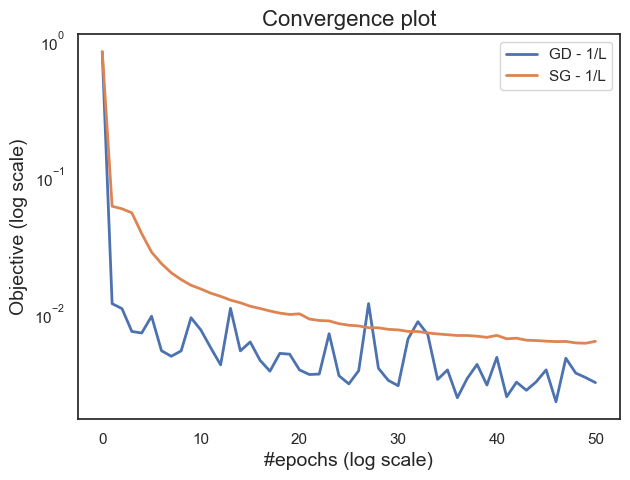

In [153]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min, label="SG - 1/L", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

## Question 3

In [146]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 50
n = binclass_a9a.n
nbset = 1
x0 = np.zeros(d)

replace_batch=False

# Stochastic gradient (batch size 1)
x_a, obj_a, nits_a = stoch_grad(x0, binclass_a9a, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs*n/nbset), nb=1)

# Batch stochastic gradient (batch size n/677)
nbset=int(n/644)
x_b, obj_b, nits_b = stoch_grad(x0, binclass_a9a, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs*n/nbset), nb=nbset, with_replace=replace_batch)

# Batch stochastic gradient (batch size n/12)
nbset=int(n/25)
x_c, obj_c, nits_c = stoch_grad(x0, binclass_a9a, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs*n/nbset), nb=nbset, with_replace=replace_batch)

# Batch stochastic gradient (batch size n/2)
nbset=int(n/2)
x_d, obj_d, nits_d = stoch_grad(x0, binclass_a9a, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs*n/nbset), nb=nbset, with_replace=replace_batch)

# Gradient descent (batch size n, taken without replacement)
x_f, obj_f, nits_f = stoch_grad(x0, binclass_a9a, x_min, stepchoice=0, step0=1, n_iter=int(nb_epochs), nb=n)

Stochastic Gradient, batch size= 1 / 16100
  iter   |   fval   |  normit 
       0 | 1.76e+00 | 2.10e+02
   16100 | 9.53e-01 | 2.09e+02
   32200 | 9.52e-01 | 2.08e+02
   48300 | 9.49e-01 | 2.08e+02
   64400 | 9.49e-01 | 2.08e+02
   80500 | 9.51e-01 | 2.08e+02
   96600 | 9.47e-01 | 2.07e+02
  112700 | 9.46e-01 | 2.07e+02
  128800 | 9.47e-01 | 2.07e+02
  144900 | 9.51e-01 | 2.07e+02
  161000 | 9.49e-01 | 2.07e+02
  177100 | 9.47e-01 | 2.06e+02
  193200 | 9.46e-01 | 2.06e+02
  209300 | 9.52e-01 | 2.06e+02
  225400 | 9.47e-01 | 2.06e+02
  241500 | 9.48e-01 | 2.06e+02
  257600 | 9.46e-01 | 2.06e+02
  273700 | 9.45e-01 | 2.05e+02
  289800 | 9.47e-01 | 2.05e+02
  305900 | 9.46e-01 | 2.05e+02
  322000 | 9.45e-01 | 2.05e+02
  338100 | 9.45e-01 | 2.05e+02
  354200 | 9.45e-01 | 2.05e+02
  370300 | 9.49e-01 | 2.05e+02
  386400 | 9.45e-01 | 2.05e+02
  402500 | 9.45e-01 | 2.05e+02
  418600 | 9.45e-01 | 2.04e+02
  434700 | 9.53e-01 | 2.04e+02
  450800 | 9.45e-01 | 2.04e+02
  466900 | 9.45e-01 | 2.04e

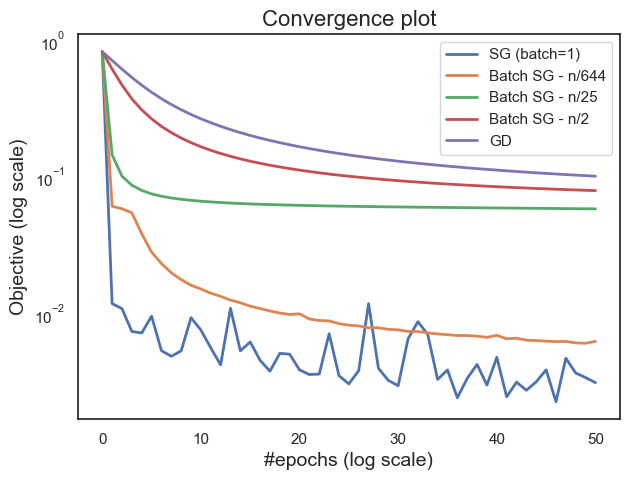

In [152]:
# Plot the comparison of variants of batch SGD with the same stepsize rule

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min, label="Batch SG - n/644", lw=2)
plt.semilogy(obj_c-f_min, label="Batch SG - n/25", lw=2)
plt.semilogy(obj_d-f_min, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_f-f_min, label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

## Question 4

Iteration 1: Objective = 1.64e+00, Distance to target = 2.10e+02
Iteration 2: Objective = 1.53e+00, Distance to target = 2.10e+02
Iteration 3: Objective = 1.47e+00, Distance to target = 2.10e+02
Iteration 4: Objective = 1.42e+00, Distance to target = 2.10e+02
Iteration 5: Objective = 1.38e+00, Distance to target = 2.10e+02
Iteration 6: Objective = 1.34e+00, Distance to target = 2.10e+02
Iteration 7: Objective = 1.31e+00, Distance to target = 2.10e+02
Iteration 8: Objective = 1.29e+00, Distance to target = 2.10e+02
Iteration 9: Objective = 1.26e+00, Distance to target = 2.10e+02
Iteration 10: Objective = 1.24e+00, Distance to target = 2.10e+02
Iteration 11: Objective = 1.22e+00, Distance to target = 2.10e+02
Iteration 12: Objective = 1.20e+00, Distance to target = 2.10e+02
Iteration 13: Objective = 1.19e+00, Distance to target = 2.10e+02
Iteration 14: Objective = 1.17e+00, Distance to target = 2.10e+02
Iteration 15: Objective = 1.16e+00, Distance to target = 2.10e+02
Iteration 16: Objec

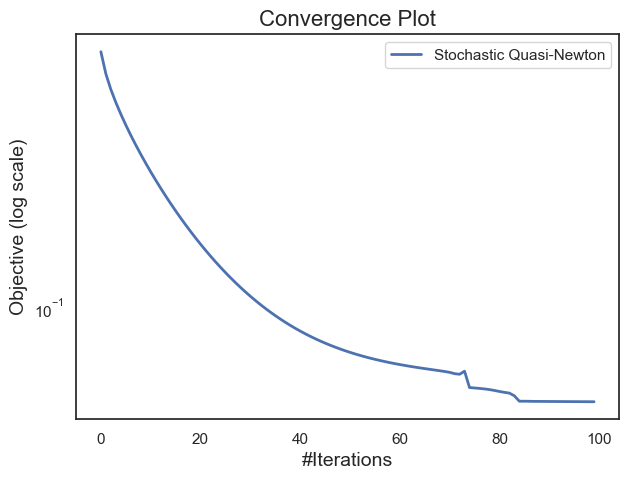

In [13]:
class StochasticQuasiNewtonMethod:
    def __init__(self, problem, xtarget, batch_size, m=10, n_iter=100, alpha=0.01, verbose=True):
        self.problem = problem
        self.xtarget = xtarget
        self.batch_size = batch_size
        self.m = m
        self.n_iter = n_iter
        self.alpha = alpha
        self.verbose = verbose

    def bfgs_update(self, Hk, sk, vk):
        rho = 1.0 / np.dot(vk, sk)
        outer_sk_vk = np.outer(sk, vk)
        Hk_new = (np.identity(len(sk)) - rho * outer_sk_vk).T @ Hk @ (np.identity(len(sk)) - rho * outer_sk_vk) + rho * np.outer(sk, sk)
        return Hk_new

    def optimize(self, initial_x):
        xk = initial_x
        Hk = np.identity(self.problem.d)  # Start with the identity matrix
        objvals = []
        normits = []

        for k in range(self.n_iter):
            np.random.seed(1)
            
            batch_indices = np.random.choice(self.problem.n, self.batch_size, replace=False)
            grad = np.mean([self.problem.grad_i(i, xk) for i in batch_indices], axis=0)

            # Update xk
            pk = -np.dot(Hk, grad)
            xk_new = xk + self.alpha * pk

            # Compute sk and vk for BFGS update
            sk = xk_new - xk
            grad_new = np.mean([self.problem.grad_i(i, xk_new) for i in batch_indices], axis=0)
            vk = grad_new - grad

            if np.dot(sk, vk) > 0:
                Hk = self.bfgs_update(Hk, sk, vk)

            xk = xk_new

            # Tracking and printing progress
            obj = self.problem.fun(xk)
            nmin = norm(xk - self.xtarget)
            objvals.append(obj)
            normits.append(nmin)
            if self.verbose:
                print(f'Iteration {k+1}: Objective = {obj:.2e}, Distance to target = {nmin:.2e}')

        return xk, np.array(objvals), np.array(normits)
    
    def plot_results(self, objvals, f_min, title="Convergence Plot"):
        plt.figure(figsize=(7, 5))

        # Adjust if f_min is a single value or an array
        if np.isscalar(f_min):
            f_min = f_min * np.ones_like(objvals)

        plt.semilogy(objvals - f_min, label="Stochastic Quasi-Newton", lw=2)

        plt.title(title, fontsize=16)
        plt.xlabel("#Iterations", fontsize=14)
        plt.ylabel("Objective (log scale)", fontsize=14)
        plt.legend()
        plt.show()

# Example usage
problem = BinClass(A, y)
xtarget = x_min  # Target minimum (if known, otherwise use a zero vector or another reference)
optimizer = StochasticQuasiNewtonMethod(problem, xtarget, batch_size=100, m=10, n_iter=100, alpha=1/problem.lipgrad(), verbose=True)
initial_x = np.zeros(problem.d)  # Initial guess

# Optimizer returns the optimized parameters, objective values, and normits
optimized_x, objvals, normits = optimizer.optimize(initial_x)

# Plot the results
optimizer.plot_results(objvals, f_min)

Batch Stochastic Quasi-Newton, batch size= 100 / 16100
  iter   |   fval   |   norm  
       1 | 1.64e+00 | 9.98e-02
       2 | 1.53e+00 | 1.98e-01
       3 | 1.47e+00 | 2.64e-01
       4 | 1.42e+00 | 3.17e-01
       5 | 1.38e+00 | 3.65e-01
       6 | 1.34e+00 | 4.09e-01
       7 | 1.31e+00 | 4.50e-01
       8 | 1.29e+00 | 4.89e-01
       9 | 1.26e+00 | 5.27e-01
      10 | 1.24e+00 | 5.63e-01
      11 | 1.22e+00 | 5.98e-01
      12 | 1.20e+00 | 6.32e-01
      13 | 1.19e+00 | 6.65e-01
      14 | 1.17e+00 | 6.98e-01
      15 | 1.16e+00 | 7.30e-01
      16 | 1.15e+00 | 7.61e-01
      17 | 1.14e+00 | 7.93e-01
      18 | 1.13e+00 | 8.23e-01
      19 | 1.12e+00 | 8.54e-01
      20 | 1.11e+00 | 8.84e-01
      21 | 1.10e+00 | 9.13e-01
      22 | 1.10e+00 | 9.43e-01
      23 | 1.09e+00 | 9.72e-01
      24 | 1.08e+00 | 1.00e+00
      25 | 1.08e+00 | 1.03e+00
      26 | 1.07e+00 | 1.06e+00
      27 | 1.07e+00 | 1.09e+00
      28 | 1.06e+00 | 1.12e+00
      29 | 1.06e+00 | 1.14e+00
      30 | 1.05

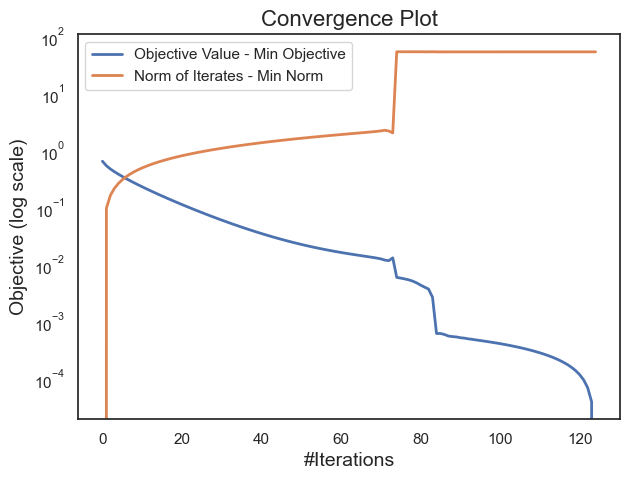

In [30]:
def bfgs_update(Hk, sk, vk):
    """ Update Hessian approximation using the BFGS formula. """
    rho = 1.0 / np.dot(vk, sk)
    I = np.eye(len(sk))
    Vk = np.outer(vk, sk)
    Hk = (I - rho * Vk) @ Hk @ (I - rho * Vk.T) + rho * np.outer(sk, sk)
    return Hk

def batch_stochastic_quasi_newton(bin_class, x0, batch_size, max_iter=100, alpha=0.1, verbose=True):
    """ Batch stochastic quasi-Newton method using BFGS for binary classification. """
    n = bin_class.d
    Hk = np.eye(n)
    xk = x0

    objvals = []
    normits = []

    if verbose:
        print("Batch Stochastic Quasi-Newton, batch size=", batch_size, "/", bin_class.n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "norm"]]))

    for k in range(max_iter):
        np.random.seed(1)
        
        # Randomly select a batch
        batch_indices = np.random.choice(bin_class.n, batch_size, replace=False)
        grad = np.mean([bin_class.grad_i(i, xk) for i in batch_indices], axis=0)

        # Update step
        pk = -np.dot(Hk, grad)
        xk1 = xk + alpha * pk

        # Compute s_k and v_k
        sk = xk1 - xk
        vk = np.mean([bin_class.grad_i(i, xk1) - bin_class.grad_i(i, xk) for i in batch_indices], axis=0)

        # BFGS update
        if np.dot(sk, vk) > 0:
            Hk = bfgs_update(Hk, sk, vk)

        # Update iterate
        xk = xk1

        # Record objective value and norm
        objvals.append(bin_class.fun(xk))
        normits.append(np.linalg.norm(xk))

        # Log information
        if verbose:
            print(' | '.join([("%d" % (k+1)).rjust(8), ("%.2e" % objvals[-1]).rjust(8), ("%.2e" % normits[-1]).rjust(8)]))

    # Plot convergence
    plt.figure(figsize=(7, 5))

    # Plot objective value convergence
    f_min = min(objvals)  # Assuming f_min as the minimum of objective values recorded
    plt.semilogy([o - f_min for o in objvals], label='Objective Value - Min Objective', lw=2)

    # Plot norm of iterates convergence
    min_norm = min(normits)  # Assuming min_norm as the minimum of norms recorded
    plt.semilogy([n - min_norm for n in normits], label='Norm of Iterates - Min Norm', lw=2)

    plt.title('Convergence Plot', fontsize=16)
    plt.xlabel('#Iterations', fontsize=14)
    plt.ylabel('Objective (log scale)', fontsize=14)
    plt.legend()
    plt.show()

    return xk

# Example usage
nb_epochs = 50
nbset = 100
L = binclass_a9a.lipgrad()
n_iter=int(nb_epochs*n/nbset)
x0 = np.zeros(d) # Starting point

x_opt = batch_stochastic_quasi_newton(binclass_a9a, x0, batch_size=100, max_iter=125, alpha=1/L)

Iteration: 1 Objective Value: 1.6482e+00 Norm of x: 9.4144e-02
Iteration: 2 Objective Value: 1.5650e+00 Norm of x: 1.6762e-01
Iteration: 3 Objective Value: 1.4903e+00 Norm of x: 2.3850e-01
Iteration: 4 Objective Value: 1.4365e+00 Norm of x: 2.9525e-01
Iteration: 5 Objective Value: 1.4011e+00 Norm of x: 3.3649e-01
Iteration: 6 Objective Value: 1.3709e+00 Norm of x: 3.7135e-01
Iteration: 7 Objective Value: 1.3393e+00 Norm of x: 4.1186e-01
Iteration: 8 Objective Value: 1.3049e+00 Norm of x: 4.5919e-01
Iteration: 9 Objective Value: 1.2842e+00 Norm of x: 4.8986e-01
Iteration: 10 Objective Value: 1.2641e+00 Norm of x: 5.3499e-01
Iteration: 11 Objective Value: 1.2096e+00 Norm of x: 7.0242e-01
Iteration: 12 Objective Value: 1.1763e+00 Norm of x: 9.1994e-01
Iteration: 13 Objective Value: 1.1241e+00 Norm of x: 1.0534e+00
Iteration: 14 Objective Value: 1.0982e+00 Norm of x: 1.1853e+00
Iteration: 15 Objective Value: 1.0862e+00 Norm of x: 1.1632e+00
Iteration: 16 Objective Value: 1.0718e+00 Norm of

C:\Users\jules\AppData\Local\Temp\ipykernel_14564\2187573294.py:36: RuntimeWarning: overflow encountered in power
  denom = (1 + exp_Aix) ** 3
C:\Users\jules\AppData\Local\Temp\ipykernel_14564\2187573294.py:35: RuntimeWarning: overflow encountered in multiply
  num = 2 * exp_Aix * (exp_Aix * (self.y[i] - 1) + self.y[i])
C:\Users\jules\AppData\Local\Temp\ipykernel_14564\2187573294.py:37: RuntimeWarning: invalid value encountered in divide
  grad = -(num / denom) * self.A[i]


Iteration: 30 Objective Value: nan Norm of x: nan
Iteration: 31 Objective Value: nan Norm of x: nan
Iteration: 32 Objective Value: nan Norm of x: nan
Iteration: 33 Objective Value: nan Norm of x: nan
Iteration: 34 Objective Value: nan Norm of x: nan
Iteration: 35 Objective Value: nan Norm of x: nan
Iteration: 36 Objective Value: nan Norm of x: nan
Iteration: 37 Objective Value: nan Norm of x: nan
Iteration: 38 Objective Value: nan Norm of x: nan
Iteration: 39 Objective Value: nan Norm of x: nan
Iteration: 40 Objective Value: nan Norm of x: nan
Iteration: 41 Objective Value: nan Norm of x: nan
Iteration: 42 Objective Value: nan Norm of x: nan
Iteration: 43 Objective Value: nan Norm of x: nan
Iteration: 44 Objective Value: nan Norm of x: nan
Iteration: 45 Objective Value: nan Norm of x: nan
Iteration: 46 Objective Value: nan Norm of x: nan
Iteration: 47 Objective Value: nan Norm of x: nan
Iteration: 48 Objective Value: nan Norm of x: nan
Iteration: 49 Objective Value: nan Norm of x: nan


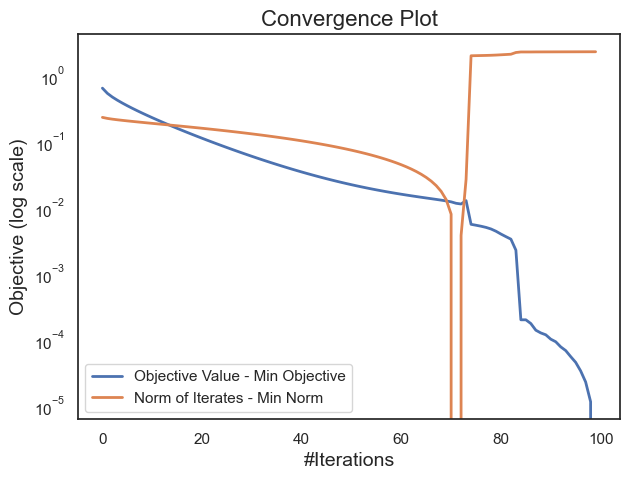

In [33]:
def lbfgs_update(m, H0, s_list, v_list):
    """ Perform the L-BFGS update. """
    Hk = np.array(H0)
    alpha_list = []
    
    # First loop of L-BFGS (Algorithm 1, lines 4-5)
    for i in range(min(m, len(s_list)) - 1, -1, -1):
        si = s_list[i]
        vi = v_list[i]
        rho_i = 1.0 / np.dot(si, vi)
        
        alpha_i = rho_i * np.dot(si, Hk)
        Hk -= np.outer(alpha_i, vi)
        alpha_list.append(alpha_i)
    
    # Second loop of L-BFGS (not explicitly shown in Algorithm 1)
    for i in range(len(alpha_list)):
        beta = np.dot(v_list[i], Hk) * (1.0 / np.dot(s_list[i], v_list[i]))
        Hk += np.outer(s_list[i], alpha_list[-i-1] - beta)
    
    return Hk

def batch_stochastic_quasi_newton_lbfgs(bin_class, x0, batch_size, m, max_iter=100, alpha=0.1, verbose=True):
    """ Batch stochastic quasi-Newton method using L-BFGS for binary classification. """
    n = bin_class.d
    H0 = np.eye(n)  # Initial Hessian approximation is the identity matrix
    xk = x0
    
    # Lists to hold the most recent m pairs of (s, v)
    s_list = []
    v_list = []

    for k in range(max_iter):
        # Randomly select a batch
        batch_indices = np.random.choice(bin_class.n, batch_size, replace=False)
        grad = np.mean([bin_class.grad_i(i, xk) for i in batch_indices], axis=0)

        # Compute search direction using the current Hessian approximation
        Hk = lbfgs_update(m, H0, s_list, v_list)
        pk = -np.dot(Hk, grad)
        
        # Update step
        xk1 = xk + alpha * pk

        # Compute s_k and v_k
        sk = xk1 - xk
        vk = np.mean([bin_class.grad_i(i, xk1) - bin_class.grad_i(i, xk) for i in batch_indices], axis=0)

        # Update the pairs of (s, v), keeping only the most recent m pairs
        if len(s_list) >= m:
            s_list.pop(0)
            v_list.pop(0)
        s_list.append(sk)
        v_list.append(vk)

        # Move to the next iteration
        xk = xk1

        if verbose:
            # Compute objective value for logging purposes
            objval = bin_class.fun(xk)
            norm_xk = np.linalg.norm(xk)
            print('Iteration:', k+1, 'Objective Value:', "%.4e" % objval, 'Norm of x:', "%.4e" % norm_xk)
    
    # If plotting is desired, the user would call an external plot function here.
    # Plot convergence
    plt.figure(figsize=(7, 5))

    # Plot objective value convergence
    f_min = min(objvals)  # Assuming f_min as the minimum of objective values recorded
    plt.semilogy([o - f_min for o in objvals], label='Objective Value - Min Objective', lw=2)

    # Plot norm of iterates convergence
    min_norm = min(normits)  # Assuming min_norm as the minimum of norms recorded
    plt.semilogy([n - min_norm for n in normits], label='Norm of Iterates - Min Norm', lw=2)

    plt.title('Convergence Plot', fontsize=16)
    plt.xlabel('#Iterations', fontsize=14)
    plt.ylabel('Objective (log scale)', fontsize=14)
    plt.legend()
    plt.show()

    return xk

# Example usage
nb_epochs = 50
nbset = 100
L = binclass_a9a.lipgrad()
n_iter=int(nb_epochs*n/nbset)
x0 = np.zeros(d) # Starting point

x_opt = batch_stochastic_quasi_newton_lbfgs(binclass_a9a, x0, batch_size=100, m=10, max_iter=125, alpha=1/L)

Batch Stochastic Quasi-Newton (L-BFGS), batch size= 100 / 16100
  iter   |   fval   |   norm  
       1 | 1.75e+00 | 7.00e-03
       2 | 1.76e+00 | 6.19e-03
       3 | 1.76e+00 | 7.12e-03
       4 | 1.76e+00 | 8.19e-03
       5 | 1.76e+00 | 9.69e-03
       6 | 1.76e+00 | 9.05e-03
       7 | 1.76e+00 | 9.03e-03
       8 | 1.76e+00 | 9.01e-03
       9 | 1.76e+00 | 8.89e-03
      10 | 1.76e+00 | 9.10e-03
      11 | 1.76e+00 | 9.02e-03
      12 | 1.76e+00 | 9.55e-03
      13 | 1.76e+00 | 9.40e-03
      14 | 1.76e+00 | 9.63e-03
      15 | 1.76e+00 | 9.48e-03
      16 | 1.76e+00 | 9.44e-03
      17 | 1.76e+00 | 9.57e-03
      18 | 1.76e+00 | 9.48e-03
      19 | 1.76e+00 | 9.69e-03
      20 | 1.76e+00 | 9.61e-03
      21 | 1.76e+00 | 9.62e-03
      22 | 1.76e+00 | 9.64e-03
      23 | 1.76e+00 | 9.76e-03
      24 | 1.76e+00 | 9.49e-03
      25 | 1.76e+00 | 9.64e-03
      26 | 1.76e+00 | 1.06e-02
      27 | 1.76e+00 | 9.84e-03
      28 | 1.76e+00 | 9.93e-03
      29 | 1.76e+00 | 1.02e-02
      

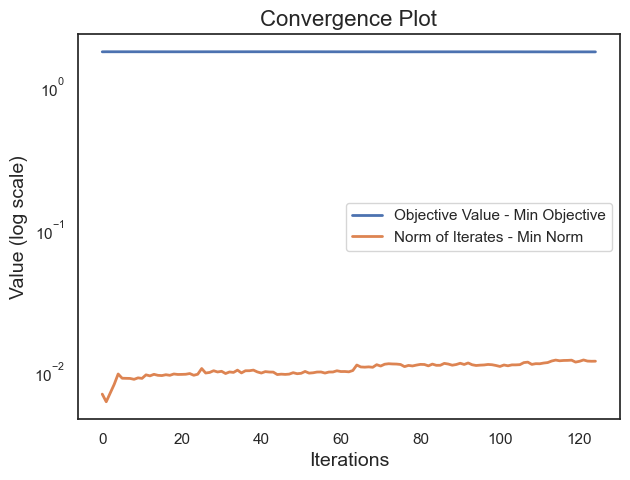

In [38]:
def lbfgs_update(xk, xk1, grad_xk, grad_xk1, m, s_history, v_history):
    """ Limited-memory BFGS update. """
    sk = xk1 - xk
    vk = grad_xk1 - grad_xk
    
    if len(s_history) >= m:
        s_history.pop(0)
        v_history.pop(0)
    
    s_history.append(sk)
    v_history.append(vk)
    
    q = vk
    alphas = []
    rhos = []
    
    # First loop
    for i in range(len(s_history) - 1, -1, -1):
        si = s_history[i]
        vi = v_history[i]
        rho_i = 1.0 / np.dot(vi, si)
        rhos.append(rho_i)
        alpha_i = rho_i * np.dot(si, q)
        alphas.append(alpha_i)
        q = q - alpha_i * vi
    
    r = q  # Assuming the initial Hk0 is the identity matrix
    
    # Second loop
    for i in range(len(s_history)):
        si = s_history[i]
        vi = v_history[i]
        beta = rhos[i] * np.dot(vi, r)
        r = r + si * (alphas[i] - beta)
    
    return r

def batch_stochastic_quasi_newton(bin_class, x0, batch_size, m, max_iter=100, alpha=0.1, verbose=True):
    """ Batch stochastic quasi-Newton method using L-BFGS for binary classification. """
    xk = x0
    grad_xk = bin_class.grad(xk)

    s_history = []
    v_history = []
    objvals = []
    normits = []

    if verbose:
        print("Batch Stochastic Quasi-Newton (L-BFGS), batch size=", batch_size, "/", bin_class.n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "norm"]]))

    for k in range(max_iter):
        # Randomly select a batch
        batch_indices = np.random.choice(bin_class.n, batch_size, replace=False)
        grad = np.mean([bin_class.grad_i(i, xk) for i in batch_indices], axis=0)

        # L-BFGS update to find search direction pk
        pk = lbfgs_update(xk, xk - alpha * grad, grad_xk, grad - grad_xk, m, s_history, v_history)

        # Update step
        xk1 = xk + alpha * pk
        grad_xk1 = np.mean([bin_class.grad_i(i, xk1) for i in batch_indices], axis=0)

        # Bookkeeping for convergence plot and verbose output
        obj = bin_class.fun(xk1)
        objvals.append(obj)
        norm_xk1 = np.linalg.norm(xk1)
        normits.append(norm_xk1)
        
        if verbose:
            print(' | '.join([("%d" % (k+1)).rjust(8), ("%.2e" % obj).rjust(8), ("%.2e" % norm_xk1).rjust(8)]))
        
        # Update iterate and gradient
        xk = xk1
        grad_xk = grad_xk1

    # Plot convergence
    plt.figure(figsize=(7, 5))
    plt.semilogy(objvals, label='Objective Value - Min Objective', lw=2)
    plt.semilogy(normits, label='Norm of Iterates - Min Norm', lw=2)
    plt.title('Convergence Plot', fontsize=16)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Value (log scale)', fontsize=14)
    plt.legend()
    plt.show()

    return xk


# Example usage
nb_epochs = 50
nbset = 100
L = binclass_a9a.lipgrad()
n_iter=int(nb_epochs*n/nbset)
x0 = np.zeros(d) # Starting point

x_opt = batch_stochastic_quasi_newton(binclass_a9a, x0, batch_size=100, m=5, max_iter=125, alpha=1/L)